Dataset path: C:\Users\Prajwal\Downloads\archive\data
Classes: ['cloudy', 'desert', 'green_area', 'water']
Epoch [1/20] - Train Loss: 0.5227, Train Acc: 73.69%, Val Loss: 0.3347, Val Acc: 88.74%
Epoch [2/20] - Train Loss: 0.2921, Train Acc: 88.81%, Val Loss: 0.2737, Val Acc: 89.93%
Epoch [3/20] - Train Loss: 0.2416, Train Acc: 90.94%, Val Loss: 0.2889, Val Acc: 87.91%
Epoch [4/20] - Train Loss: 0.2412, Train Acc: 91.02%, Val Loss: 0.3329, Val Acc: 88.63%
Epoch [5/20] - Train Loss: 0.2515, Train Acc: 89.88%, Val Loss: 0.2296, Val Acc: 91.11%
Epoch [6/20] - Train Loss: 0.1798, Train Acc: 92.90%, Val Loss: 0.2431, Val Acc: 91.00%
Epoch [7/20] - Train Loss: 0.1649, Train Acc: 93.63%, Val Loss: 0.2327, Val Acc: 91.59%
Epoch [8/20] - Train Loss: 0.1582, Train Acc: 93.76%, Val Loss: 0.1999, Val Acc: 91.35%
Epoch [9/20] - Train Loss: 0.1612, Train Acc: 94.04%, Val Loss: 0.2026, Val Acc: 91.35%
Epoch [10/20] - Train Loss: 0.1482, Train Acc: 94.37%, Val Loss: 0.2325, Val Acc: 91.23%
Epoch [11/20

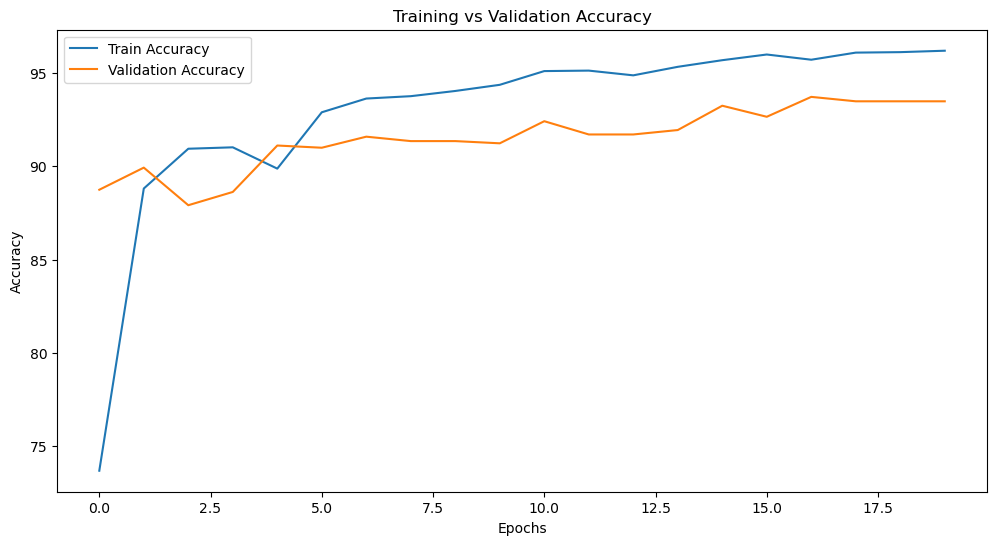

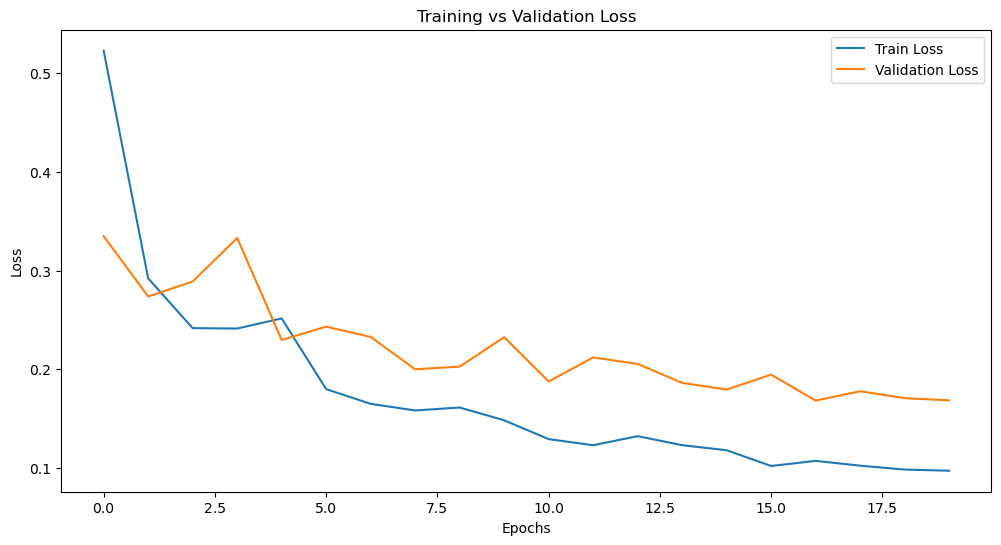

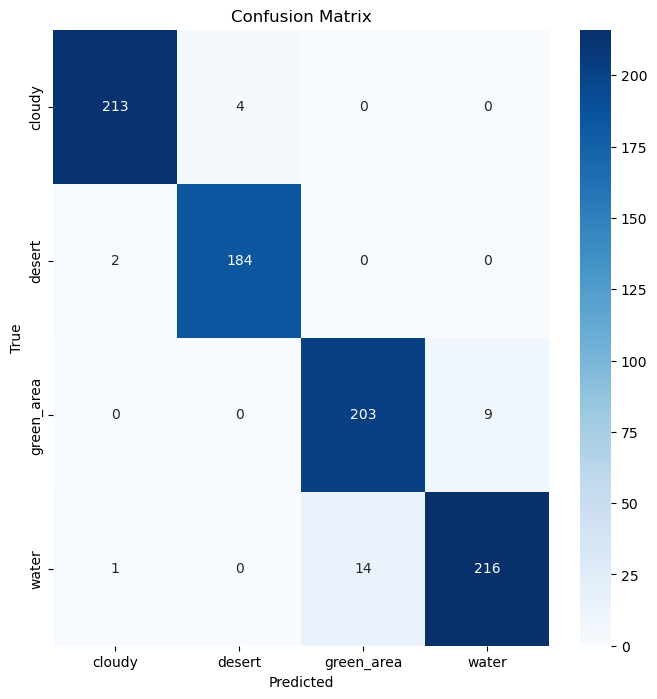

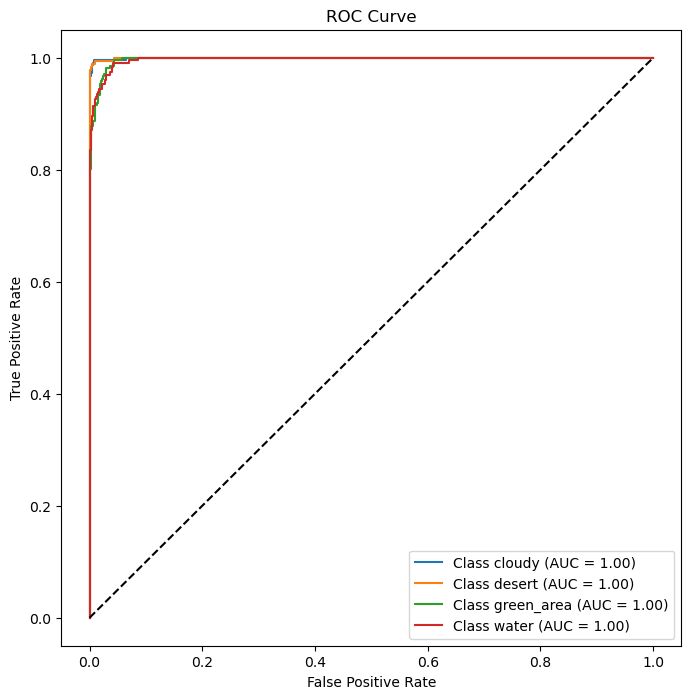

In [12]:
import os
import torch
import torchvision
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Ensure plots display correctly in Jupyter Notebook
%matplotlib inline

# Set random seed for reproducibility
seed = 1234
torch.manual_seed(seed)

# Specify dataset path
path = os.path.normpath("C:/Users/Prajwal/Downloads/archive/data")
print(f"Dataset path: {path}")

# Transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((72, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=path, transform=transform)

# Calculate dataset sizes for train, validation, and test splits
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check class names
classes = full_dataset.classes
num_classes = len(classes)
print(f"Classes: {classes}")

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 9 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, optimizer, and learning rate scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Early stopping configuration
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Training loop
epochs = 20
train_acc, val_acc = [], []
train_loss, val_loss = [], []
early_stopping = EarlyStopping(patience=5)

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / len(train_loader))

    model.eval()
    correct, total, val_running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc.append(100 * correct / total)
    val_loss.append(val_running_loss / len(val_loader))
    scheduler.step()

    print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")

    early_stopping(val_loss[-1])
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Save the trained model
save_path = "satellite_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Evaluate the model on the test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = nn.Softmax(dim=1)(model(images))
        all_probs.extend(outputs.cpu().numpy())

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
